# [프로젝트] 집 값 예측하기 - 나의 첫 번째 캐글 경진대회

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_data_path = join('~/aiffel/kaggle_kakr_housing/data/train.csv')
test_data_path = join('~/aiffel/kaggle_kakr_housing/data/test.csv')

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

### 학습 데이터와 테스트 데이터 합치기

In [144]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print('train data dim : {}'.format(train.shape))
print('sub data dim : {}'.format(test.shape))

y = train['price']

del train['price']

train_len = len(train)
train = pd.concat((train, test), axis=0)

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [145]:
train.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

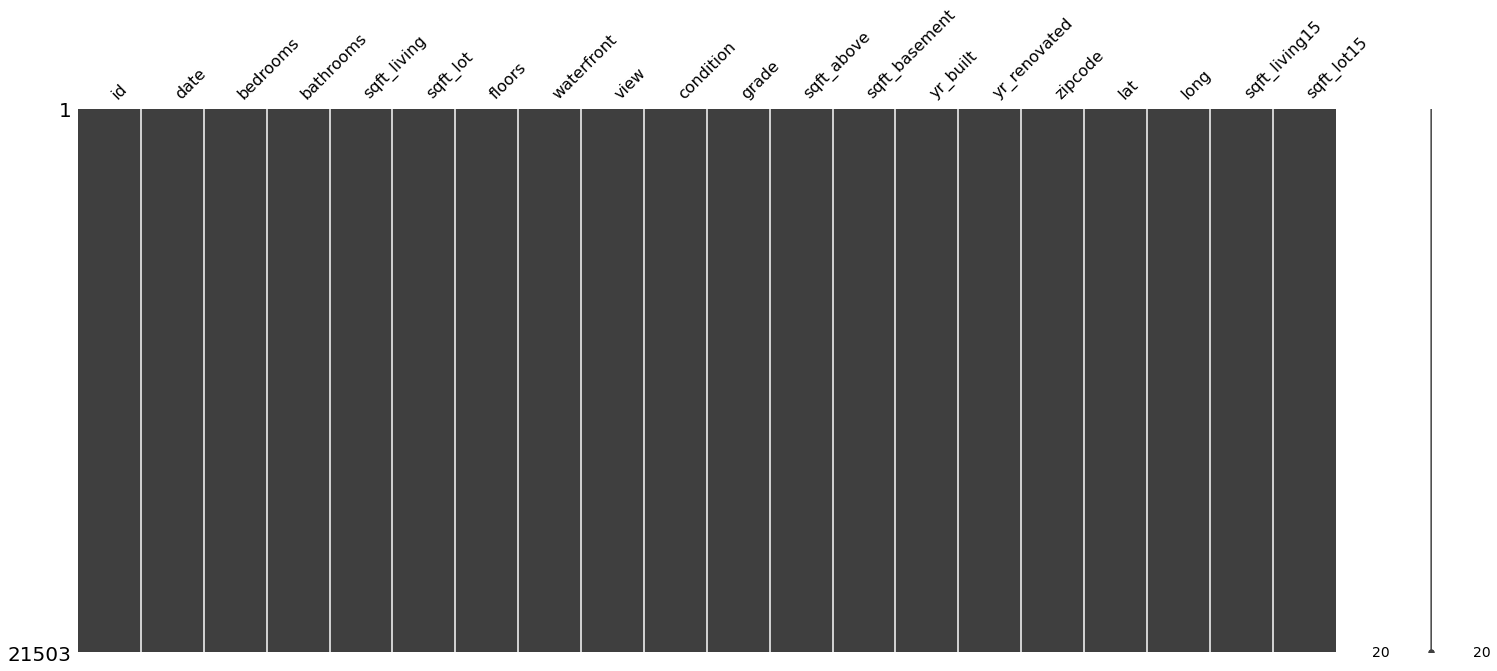

In [146]:
msno.matrix(train)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

## id 가지고 데이터프레임 인덱싱
1. id컬럼이 결측치인지 확인합니다.
2. 결측치인 데이터만 뽑아냅니다.
3. 결측치인 데이터의 개수를 셉니다.

In [147]:
# 1. id 컬럼이 결측치인지 확인합니다.
null_check = pd.isnull(train['id'])
print(null_check)

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool


In [148]:
# 2. 결측치인 데이터만 뽑아냅니다.
null_data = train.loc[null_check, 'id']
null_data.head()

Series([], Name: id, dtype: int64)

In [149]:
# 3. 결측치인 데이터의 개수를 셉니다.
print(f'id: {len(null_data.values)}')

id: 0


In [150]:
# 모든 컬럼에 적용하기
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [151]:
test_id = train['id'][train_len:]
del train['id']
train['date'] = train['date'].apply(lambda x : str(x[:6])).astype(str)

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

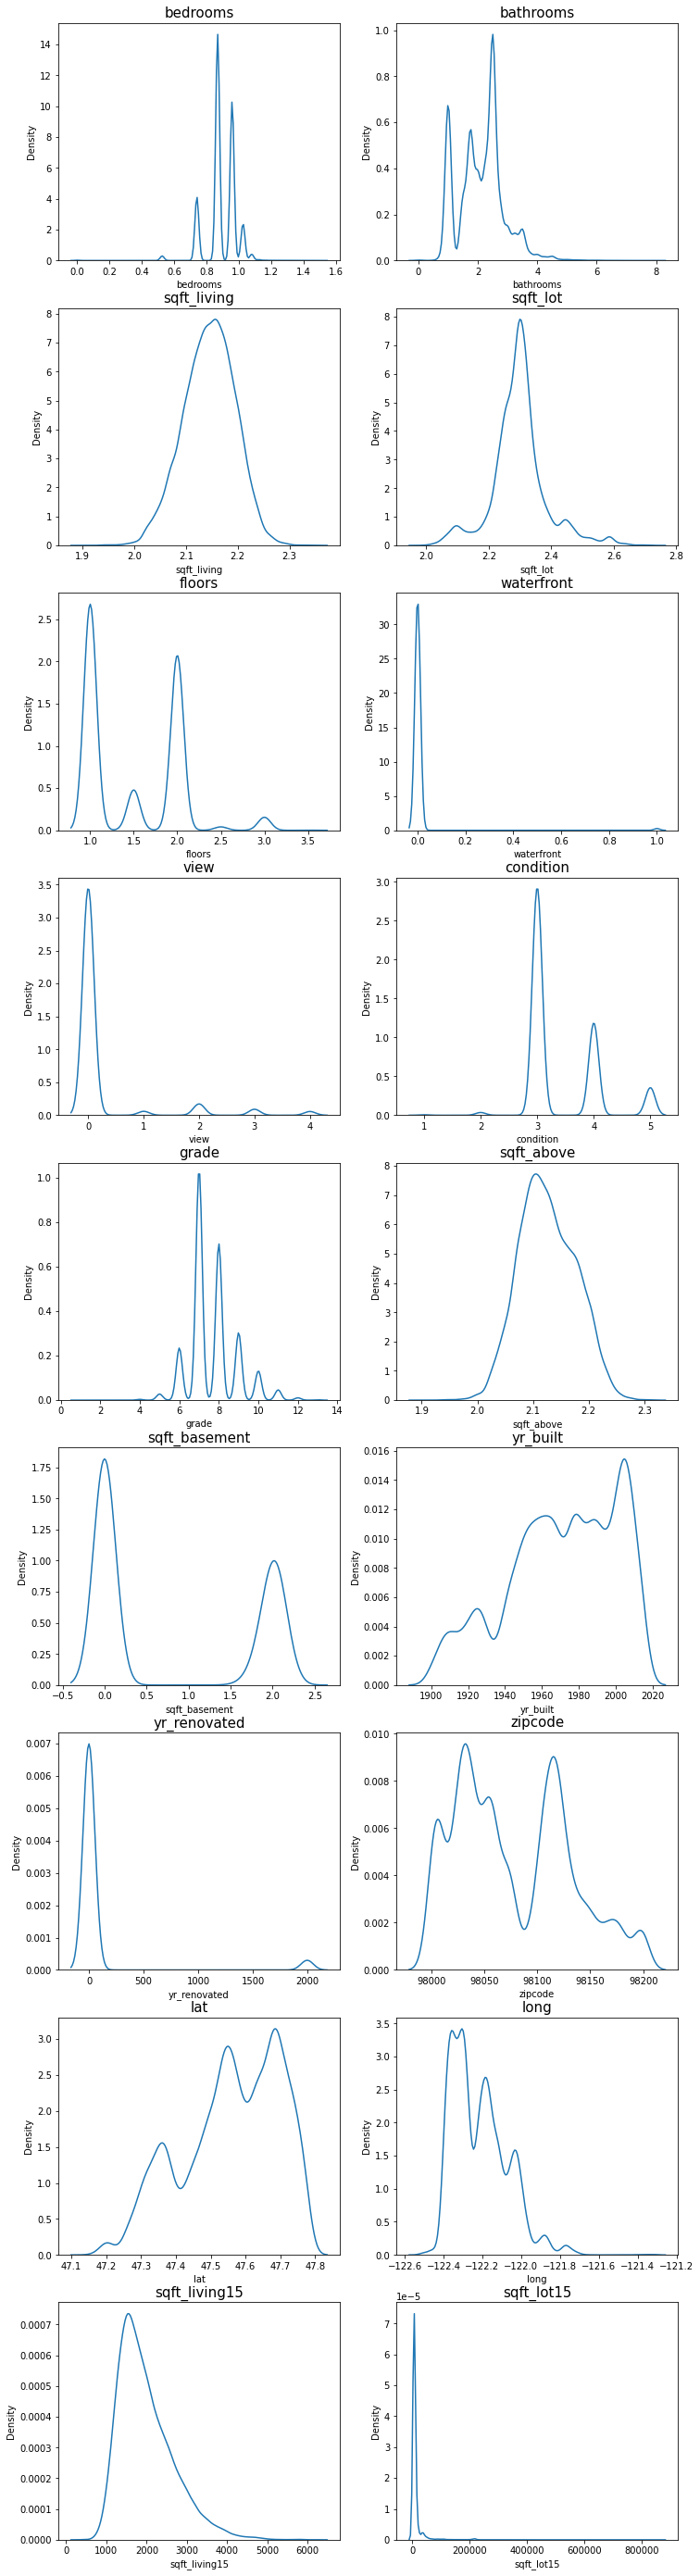

In [152]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [153]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

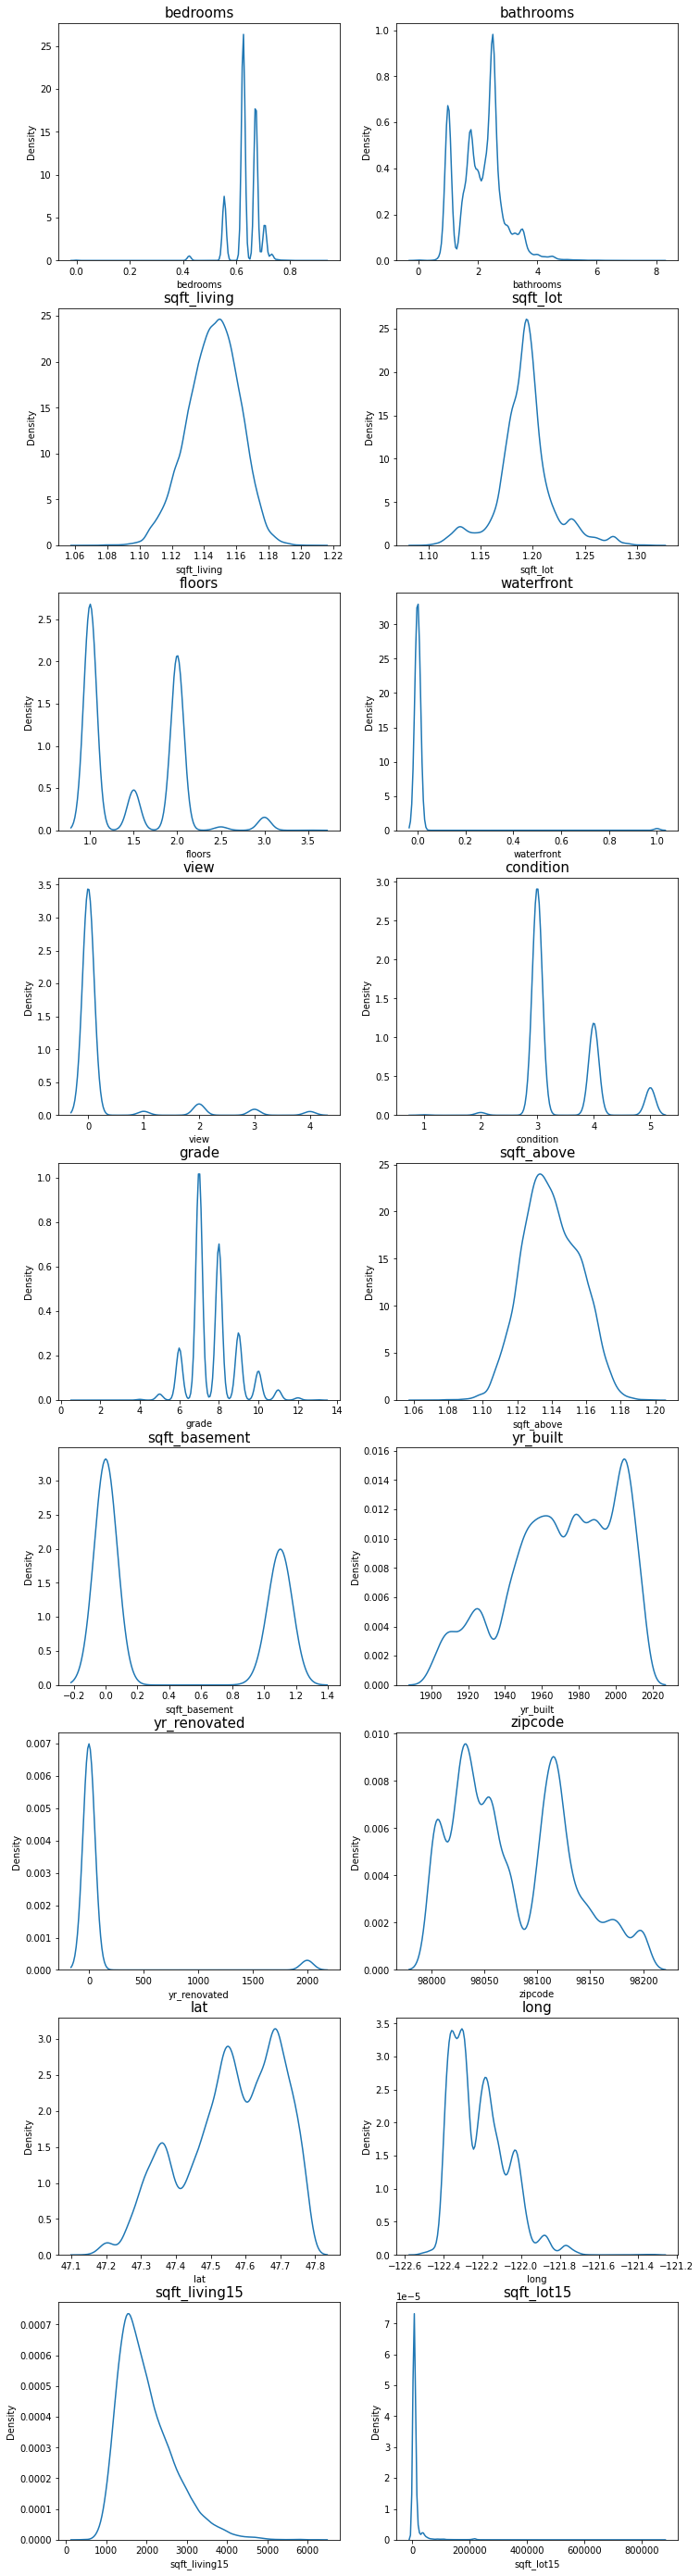

In [154]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
skew_columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

In [155]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


## 3. 모델링 & 파라미터 튜닝
### Average Blending & HyperParameter Tuning
- 여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들기
- 그리고 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기

In [4]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [5]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [6]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [7]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [8]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']
print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


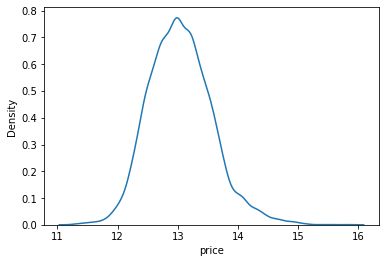

In [9]:
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [11]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [12]:
random_state=2020      
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [13]:
# 모델 이름은 __name__ 속성에 접근해서 얻음
lightgbm.__class__.__name__

'LGBMRegressor'

### RMSE 계산
`train_test_split`, `mean_squared_error` 

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [15]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [16]:
print(f"Train data shape: {train.shape}")
print(f"Target data shape: {test.shape}")

Train data shape: (15035, 19)
Target data shape: (6468, 19)


In [17]:
# 모델 별로 학습 및 예측
df = {}
    
for model in models:
    # 모델 이름
    model_name = model.__class__.__name__
    
    # 데이터셋 분리
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
    
    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)
        
    # 예측 결과 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df           

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

In [18]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

### 하이퍼 파라미터 튜닝
#### 그리드 탐색 vs 랜덤 탐색
- 그리드 탐색은 정해진 하이퍼 파라미터의 조합을 격자와 같이 탐색
- 랜덤 탐색은 랜덤으로 점을 찍어서 탐색
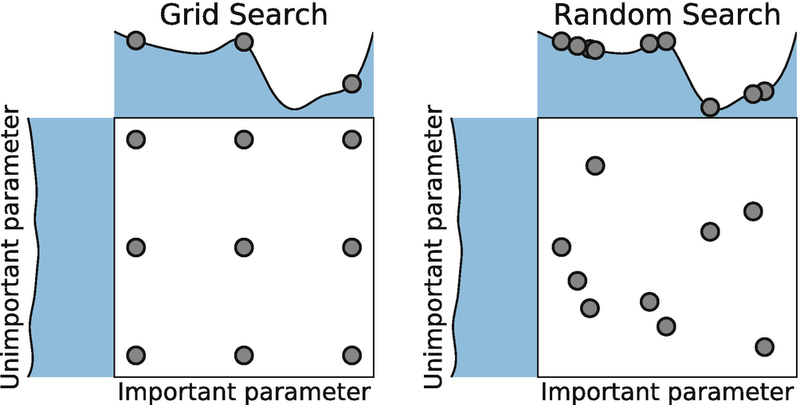

#### 그리드 탐색 : `GridSearchCV`
- param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
- scoring : 모델의 성능을 평가할 지표
- cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
- verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
- n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

In [138]:
from sklearn.model_selection import GridSearchCV
# 하이퍼 파라미터 준비
param_grid = {
    'n_estimators': [50, 100, 200,],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.05, 0.1],
}

### LightGBM(lgbm) 모델

In [139]:
# LightGBM(lgbm) 모델 준비
model = LGBMRegressor(random_state=random_state)

In [140]:
# 그리드탐색 방법을 활용한 하이퍼 파라미터 조합
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=-1)

grid_model.fit(train, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5], 'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error', verbose=1)

### LightGBM 2차)
1) param_grid 하이퍼 파라미터

    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
    
2) grid_model 하이퍼 파라미터

     grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=-1)
3) 결과

- params:
[{'learning_late': 0.1, 'max_depth': 10, 'n_estimators': 50},
 {'learning_late': 0.1, 'max_depth': 10, 'n_estimators': 100},
 {'learning_late': 0.1, 'max_depth': 10, 'n_estimators': 200}]
 
- score:
array([-0.02917734, -0.02702714, -0.02618845])

- RMSLE: 0.170814

- private score: 113112

In [112]:
from sklearn.model_selection import GridSearchCV
# 하이퍼 파라미터 준비
param_grid = {
    'n_estimators': [100],
    'max_depth': [5],
    'learning_rate': [0.01, 0.1],
    'subsample': [1.0],
    'colsample_bytree': [1.0],
    'gamma': [0.1],
    'min_child_weight': [1],
    'reg_alpha': [0.1],
    'reg_lambda': [0.1, 1.0]
    
}

### XGBoost 모델

In [113]:
# XGBoost 모델 준비
model = XGBRegressor(random_state=random_state)

In [114]:
# 그리드탐색 방법을 활용한 하이퍼 파라미터 조합
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=2, verbose=2, n_jobs=1)

grid_model.fit(train, y)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, reg_alpha=0.1, reg_lambda=1.0, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, reg_alpha=0.1, reg_lambda=1.0, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_r

GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_

### XGB 1차)
1) param_grid 하이퍼 파라미터

param_grid = {
    'n_estimators': [50, 100, 200,],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
}
    
2) grid_model 하이퍼 파라미터

    grid_model = GridSearchCV(model, param_grid=param_grid, \
                            scoring='neg_mean_squared_error', \
                            cv=5, verbose=1, n_jobs=1)
3) 결과

- params:
[{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50},
 {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100},
 {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200},
 {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50},
 {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100},
 {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200},
 {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50},
 {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100},
 {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200},
 {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 50},
 {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100},
 {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200},
 {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50},
 {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100},
 {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200},
 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 50},
 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100},
 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200},
 {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 50},
 {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100},
 {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200},
 {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 50},
 {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100},
 {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 200},
 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50},
 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100},
 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200},
 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50},
 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100},
 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200},
 {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50},
 {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100},
 {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200},
 {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50},
 {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100},
 {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}]
 
- score:
array([-5.78139045e+01, -2.12188915e+01, -2.89807323e+00, -5.78139045e+01,
       -2.12186244e+01, -2.89321621e+00, -5.78139045e+01, -2.12188149e+01,
       -2.89250211e+00, -5.78139045e+01, -2.12188149e+01, -2.89243979e+00,
       -9.91538646e-01, -4.63579345e-02, -3.37068538e-02, -9.84956679e-01,
       -3.91372189e-02, -2.87578429e-02, -9.84017109e-01, -3.63368471e-02,
       -2.69166773e-02, -9.83849130e-01, -3.51108798e-02, -2.65308993e-02,
       -4.50127247e-02, -3.37032124e-02, -3.02054314e-02, -3.79098162e-02,
       -2.90560488e-02, -2.70093100e-02, -3.52101046e-02, -2.73579291e-02,
       -2.63227256e-02, -3.41901514e-02, -2.70510320e-02, -2.68589085e-02])
- RMSLE: 7.603546

- private score: 118442

### XGB 2차)
1) param_grid 하이퍼 파라미터

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'learning_rate': [0.1],
    
}
    
2) grid_model 하이퍼 파라미터

    grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=2, n_jobs=1)
3) 결과

- params:
    [CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=   1.0s
    [CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=   1.1s
    [CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=   1.0s
    [CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=   1.1s
    [CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=   1.0s
    [CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   2.2s
    [CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   2.1s
    [CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   2.1s
    [CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   2.1s
    [CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   2.1s
    [CV] END ...learning_rate=0.1, max_depth=10, n_estimators=50; total time=   2.0s
    [CV] END ...learning_rate=0.1, max_depth=10, n_estimators=50; total time=   1.9s
    [CV] END ...learning_rate=0.1, max_depth=10, n_estimators=50; total time=   2.0s
    [CV] END ...learning_rate=0.1, max_depth=10, n_estimators=50; total time=   2.0s
    [CV] END ...learning_rate=0.1, max_depth=10, n_estimators=50; total time=   1.9s
    [CV] END ..learning_rate=0.1, max_depth=10, n_estimators=100; total time=   4.6s
    [CV] END ..learning_rate=0.1, max_depth=10, n_estimators=100; total time=   4.6s
    [CV] END ..learning_rate=0.1, max_depth=10, n_estimators=100; total time=   4.8s
    [CV] END ..learning_rate=0.1, max_depth=10, n_estimators=100; total time=   4.7s
    [CV] END ..learning_rate=0.1, max_depth=10, n_estimators=100; total time=   4.6s
 
- score:
    [{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50},
     {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100},
     {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50},
     {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}]
     
- RMSLE: 0.215159

- private score: 118442

### XGB 3차)
1) param_grid 하이퍼 파라미터

param_grid = {
    'n_estimators': [100],
    'max_depth': [5],
    'learning_rate': [0.01, 0.1],
    'subsample': [1.0],
    'colsample_bytree': [1.0],
    'gamma': [0.1],
    'min_child_weight': [1],
    'reg_alpha': [0.1],
    'reg_lambda': [0.1, 1.0]
    
}
    
2) grid_model 하이퍼 파라미터

    grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=2, n_jobs=1)

                            
3) 결과

- params:

    [{'colsample_bytree': 1.0,
      'gamma': 0.1,
      'learning_rate': 0.01,
      'max_depth': 5,
      'min_child_weight': 1,
      'n_estimators': 100,
      'reg_alpha': 0.1,
      'reg_lambda': 0.1,
      'subsample': 1.0},
     {'colsample_bytree': 1.0,
      'gamma': 0.1,
      'learning_rate': 0.01,
      'max_depth': 5,
      'min_child_weight': 1,
      'n_estimators': 100,
      'reg_alpha': 0.1,
      'reg_lambda': 1.0,
      'subsample': 1.0},
     {'colsample_bytree': 1.0,
      'gamma': 0.1,
      'learning_rate': 0.1,
      'max_depth': 5,
      'min_child_weight': 1,
      'n_estimators': 100,
      'reg_alpha': 0.1,
      'reg_lambda': 0.1,
      'subsample': 1.0},
     {'colsample_bytree': 1.0,
      'gamma': 0.1,
      'learning_rate': 0.1,
      'max_depth': 5,
      'min_child_weight': 1,
      'n_estimators': 100,
      'reg_alpha': 0.1,
      'reg_lambda': 1.0,
      'subsample': 1.0}]

 
- score: array([-21.18866914, -21.21911782,  -0.02866039,  -0.02911812])



- RMSLE: 4.606421



- private score: 116523

### RandomForestRegressor 모델

In [127]:
# 하이퍼 파라미터 준비
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
}

In [128]:
# RandomForestRegressor 모델 준비
model = RandomForestRegressor(random_state=random_state)

In [129]:
# 그리드탐색 방법을 활용한 하이퍼 파라미터 조합
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=2, n_jobs=1)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .....................max_depth=10, n_estimators=100; total time=   6.4s
[CV] END .....................max_depth=10, n_estimators=100; total time=   6.5s
[CV] END .....................max_depth=10, n_estimators=100; total time=   6.5s
[CV] END .....................max_depth=10, n_estimators=100; total time=   6.4s
[CV] END .....................max_depth=10, n_estimators=100; total time=   6.5s
[CV] END .....................max_depth=10, n_estimators=200; total time=  12.9s
[CV] END .....................max_depth=10, n_estimators=200; total time=  13.0s
[CV] END .....................max_depth=10, n_estimators=200; total time=  13.7s
[CV] END .....................max_depth=10, n_estimators=200; total time=  12.9s
[CV] END .....................max_depth=10, n_estimators=200; total time=  12.8s
[CV] END .....................max_depth=20, n_estimators=100; total time=  10.4s
[CV] END .....................max_depth=20, n_est

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=2020), n_jobs=1,
             param_grid={'max_depth': [10, 20], 'n_estimators': [100, 200]},
             scoring='neg_mean_squared_error', verbose=2)

### RandomForest 1차)
1) param_grid 하이퍼 파라미터

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20],
    }
    
2) grid_model 하이퍼 파라미터

   grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=2, n_jobs=1)
                            
3) 결과

- params:
    [{'max_depth': 10, 'n_estimators': 100},
    {'max_depth': 10, 'n_estimators': 200},
    {'max_depth': 20, 'n_estimators': 100},
    {'max_depth': 20, 'n_estimators': 200}]

 
- score: array([-0.03523222, -0.03493907, -0.03185677, -0.03153702])



- RMSLE: 0.187702



- private score: 134340.24024

### 튜닝 값 결과 저장 후 확인

In [141]:
# 파라미터 튜닝에 대한 결과 저장
grid_model.cv_results_

{'mean_fit_time': array([0.23904524, 0.357338  , 0.63374386, 0.34439878, 0.62214146,
        1.13775754, 0.23985362, 0.33459291, 0.54915643, 0.34950414,
        0.53755851, 0.92373738, 0.22550898, 0.33181667, 0.55651202,
        0.33139977, 0.52062945, 0.80441875]),
 'std_fit_time': array([0.01506761, 0.00762261, 0.003066  , 0.01677633, 0.01639377,
        0.02026766, 0.02221378, 0.00435597, 0.01395848, 0.011209  ,
        0.00673514, 0.03225185, 0.01404704, 0.02372024, 0.0173393 ,
        0.01484719, 0.02385728, 0.0897464 ]),
 'mean_score_time': array([0.01082463, 0.04033008, 0.060006  , 0.01983857, 0.03513622,
        0.04988637, 0.01910548, 0.04392371, 0.05657125, 0.0287797 ,
        0.05846162, 0.07704611, 0.012886  , 0.03137226, 0.04620581,
        0.02325072, 0.04029284, 0.07205553]),
 'std_score_time': array([0.0005281 , 0.01129949, 0.0015074 , 0.012231  , 0.01393901,
        0.0105119 , 0.00956847, 0.01137621, 0.0132862 , 0.01346172,
        0.0019364 , 0.01169799, 0.00073057, 

In [142]:
params = grid_model.cv_results_['params']
params

[{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50},
 {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100},
 {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200},
 {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50},
 {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100},
 {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200},
 {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50},
 {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100},
 {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200},
 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 50},
 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100},
 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200},
 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50},
 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100},
 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200},
 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50},
 {

In [143]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.15611745, -0.10240881, -0.06243717, -0.14071955, -0.08370028,
       -0.04671437, -0.05399165, -0.03981959, -0.03329056, -0.03995869,
       -0.03160932, -0.02864612, -0.03967106, -0.0333329 , -0.02978355,
       -0.03178273, -0.02879666, -0.02716014])

In [144]:
# 결과 데이터 프레임으로 확인하기
results = pd.DataFrame(params)
results['score'] = score

results

,learning_rate,max_depth,n_estimators,score
0,0.01,3,50,-0.156117
1,0.01,3,100,-0.102409
2,0.01,3,200,-0.062437
3,0.01,5,50,-0.140720
4,0.01,5,100,-0.083700
5,0.01,5,200,-0.046714
6,0.05,3,50,-0.053992
7,0.05,3,100,-0.039820
8,0.05,3,200,-0.033291
9,0.05,5,50,-0.039959


In [145]:
# RMLSE 점수 확인
# log를 취한 값에서 RMSE를 구했다.
results['RMSLE'] = np.sqrt(-1 * results['score'])
results = results.sort_values('RMSLE', ascending=False)

results

,learning_rate,max_depth,n_estimators,score,RMSLE
0,0.01,3,50,-0.156117,0.395117
3,0.01,5,50,-0.140720,0.375126
1,0.01,3,100,-0.102409,0.320014
4,0.01,5,100,-0.083700,0.289310
2,0.01,3,200,-0.062437,0.249874
6,0.05,3,50,-0.053992,0.232361
5,0.01,5,200,-0.046714,0.216135
9,0.05,5,50,-0.039959,0.199897
7,0.05,3,100,-0.039820,0.199548
12,0.10,3,50,-0.039671,0.199176


In [146]:
model

LGBMRegressor(random_state=2020)

## 모델 선정 및 제출
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장

In [147]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [148]:
save_submission(model, train, y, test, 'lgb_3', rmsle='0.16')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgb_3_RMSLE_0.16.csv saved!
